In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [30]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

#  Import differential peaks from last time

In [4]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output.txt',
    './ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (43605, 24)
getDiffExpression selected transcripts (42636, 33)
annotatePeaks selected peaks (42636, 24)


In [21]:
comp_dict = pull_comparisons_get_diff(diff_peak)

# Correct merge-peaks shifting of atac peak files
Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [5]:
atac_peaks = pd.read_csv('./kc_control_atac_peaks_all.txt', sep='\t', index_col=0)

In [6]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

In [7]:
diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS'])>3000, :]
atac_peaks_200bp_distal = atac_peaks_200bp.reindex(diff_peak_distal.index).dropna(how='all')

# print to check that this worked
print(diff_peak.shape[0], 'peaks in differential peak file')
print(atac_peaks_200bp.shape[0], 'peaks in ATAC-seq file')
print()
print(diff_peak_distal.shape[0], 'distal peaks in differential peak file')
print(atac_peaks_200bp_distal.shape[0], 'distal peaks in ATAC-seq file')

42636 peaks in differential peak file
43605 peaks in ATAC-seq file

26762 distal peaks in differential peak file
26762 distal peaks in ATAC-seq file


# Process in  Maggie

Here we just want to take peaks that are increased specifically in one strain when compared to another, but i would prefer to do this all in one go so that we can pool our power. Perhaps we can start by doing everything relevant to C57 - this would introduce duplicate peaks which could affect our overall power

To do this part it helps to have some understanding of the diffpeak file that homer puts out... the columns at the end are "group1 vs group2" with p value and log2fold change. The log2fold change here looks like this:  \

$\log2(\frac{group2 tags}{group1 tags})$  

So in this case things that are higher in group 1 will be negative and things that are higher in group 2 will be positive. Since C57 is group 1 in this case it all negative peaks will be up in C57

In [8]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

In [9]:
comps = ['00_c57 vs. 01_balbc', '00_c57 vs. 02_aj', '01_balbc vs. 02_aj']

In [10]:
# set cutoffs
fc = 1
pval = 0.05

for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):
    print(text, 'analysis')
    for comp in comps:
        # extract strains
        s1 = comp.split(' vs. ')[0].split('_')[1]
        s2 = comp.split(' vs. ')[1].split('_')[1]

        # write group 2 activated
        g1 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] < -fc)].index.tolist()
        print(len(g1), 'peaks upregualted in', s1, 'relative to', s2)
        atac_peaks_200bp.loc[g1, :].to_csv('./differential_peaks/'+s1+'_spec_'+s2+'_200bp'+text+'.txt', sep='\t')

        g2 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] > fc)].index.tolist()
        print(len(g2), 'peaks upregualted in', s2, 'relative to', s1)
        atac_peaks_200bp.loc[g2, :].to_csv('./differential_peaks/'+s2+'_spec_'+s1+'_200bp'+text+'.txt', sep='\t')

 analysis
1272 peaks upregualted in c57 relative to balbc
1084 peaks upregualted in balbc relative to c57
1389 peaks upregualted in c57 relative to aj
831 peaks upregualted in aj relative to c57
548 peaks upregualted in balbc relative to aj
329 peaks upregualted in aj relative to balbc
_distal analysis
963 peaks upregualted in c57 relative to balbc
877 peaks upregualted in balbc relative to c57
1101 peaks upregualted in c57 relative to aj
671 peaks upregualted in aj relative to c57
443 peaks upregualted in balbc relative to aj
247 peaks upregualted in aj relative to balbc


Extract sequences for maggie

In [11]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

In [12]:
### c57 vs balb
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_ref_200bp.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_mut_200bp.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_ref_200bp.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_mut_200bp.fa

# distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa

### balb vs aj

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_ref_200bp.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_mut_200bp.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_ref_200bp.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_mut_200bp.fa

# distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa

### c57 vs aj

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_ref_200bp.fa
marge extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_mut_200bp.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_ref_200bp.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_mut_200bp.fa

# distal

marge extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_ref_200bp_distal.fa
marge extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_spec_aj_mut_200bp_distal.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_ref_200bp_distal.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_spec_c57_mut_200bp_distal.fa


SyntaxError: invalid syntax (<ipython-input-12-947a031566b6>, line 2)

# Try running maggie with aggregated peaks

In [24]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

balbc vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_c57_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_c57_200bp_distal/ \
-p 20

aj vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/aj_c57_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/aj_c57_200bp_distal/ \
-p 20

balbc vs aj

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/balbc_ajnew_200bp/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/balbc_ajnew_200bp_distal/ \
-p 20

all c57 involved comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/c57_vs_all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/c57_vs_all_200bp_distal/ \
-p 20

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa,./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa,./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa,./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa,./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/all_200bp_distal/ \
-p 20

# Aggregate results MAGGIE

All enhancers

In [31]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

In [53]:
for i in filtered_frame.index[filtered_frame.index.duplicated()].unique():
    filtered_frame = filtered_frame.append(filtered_frame.loc[i, :].mean().rename(i+'_merge'))
    filtered_frame.drop(index=i,
                        inplace=True)

In [61]:
filtered_frame.sort_values('c57_vs_all_200bp', ascending=False)

,c57_vs_all_200bp,aj_c57_200bp,balbc_c57_200bp
Nr1h3::Rxra,15.92,7.58,9.14
IRF1_merge,15.39,6.98,9.27
ELF5_merge,12.02,9.74,NaN
SPIB,8.17,5.83,3.16
NR1H4,7.83,3.58,4.87
...,...,...,...
SIX1,NaN,NaN,2.19
RXRG,NaN,2.15,NaN
CTCFL,NaN,0.36,-2.07
NFIX,NaN,NaN,-3.28


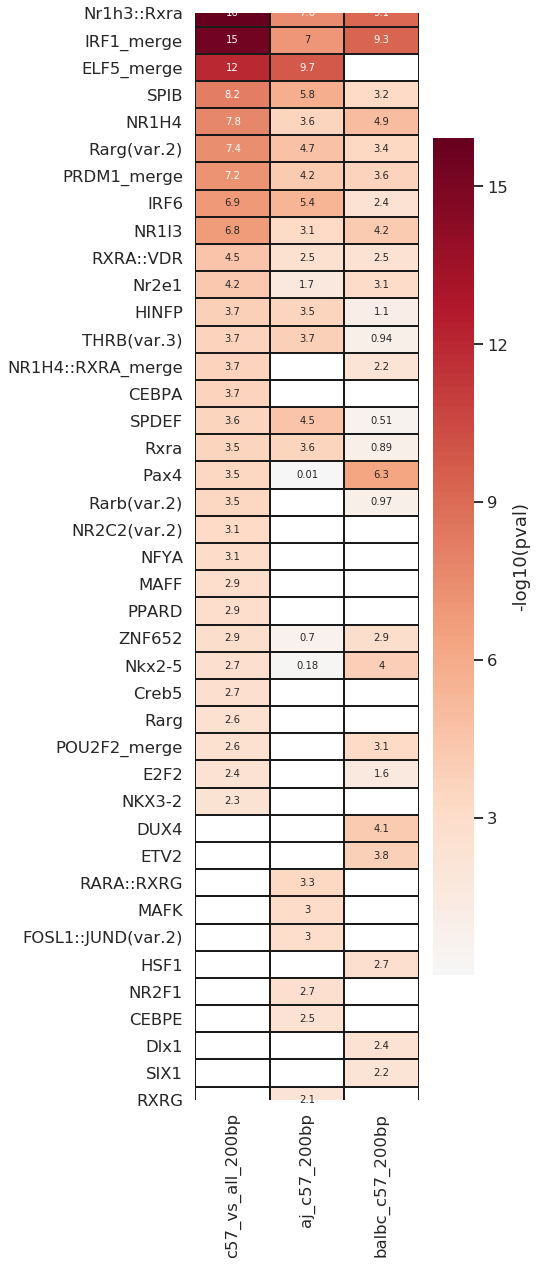

In [65]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 2), :].sort_values('c57_vs_all_200bp', ascending=False),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

#hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) > 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_activated_motifs_merged.png', bbox_inches='tight')

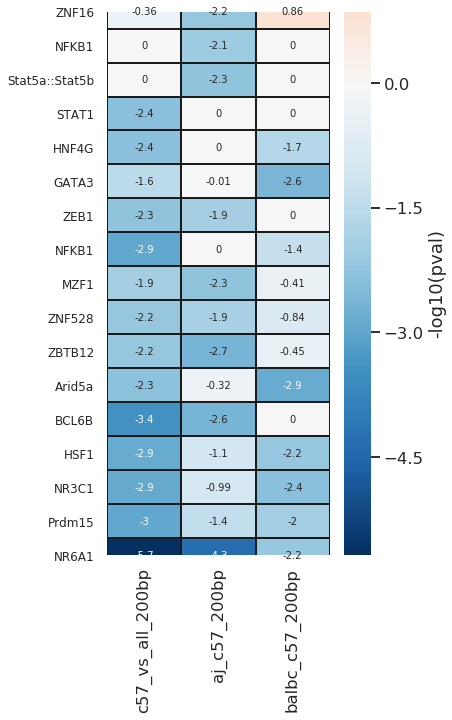

In [40]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12,
                   labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values,
                   rotation=0);

plt.savefig('./figures/maggie_repressing_motifs_merged.png', bbox_inches='tight')

### Distal enhancers

In [95]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp_distal/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        df = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = df.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

In [76]:
# for i in filtered_frame.index[filtered_frame.index.duplicated()].unique():
#     filtered_frame = filtered_frame.append(filtered_frame.loc[i, :].mean().rename(i+'_merge'))
#     filtered_frame.drop(index=i,
#                         inplace=True)

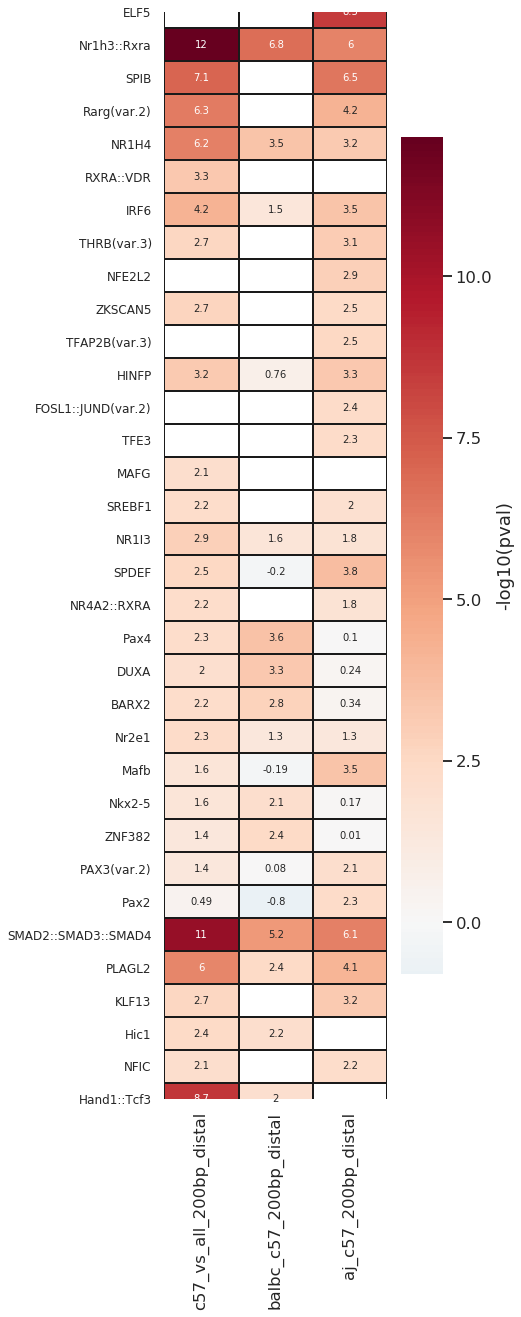

In [77]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged.png', bbox_inches='tight')

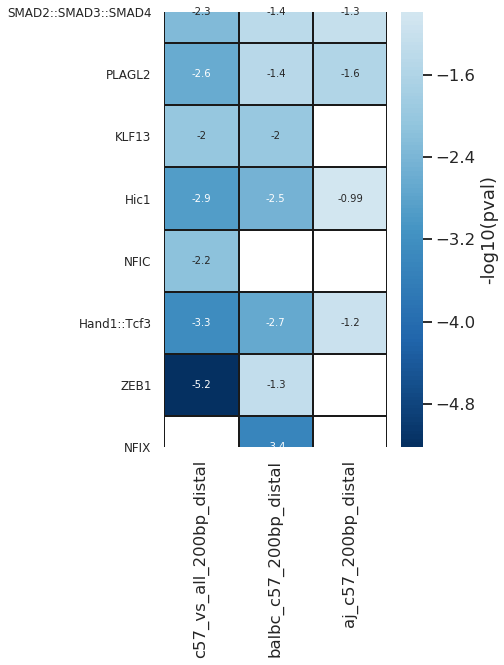

In [78]:
fig, ax = plt.subplots(figsize=(5,8))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged.png', bbox_inches='tight')

### Plot with just the top motifs from c57_vs_all 

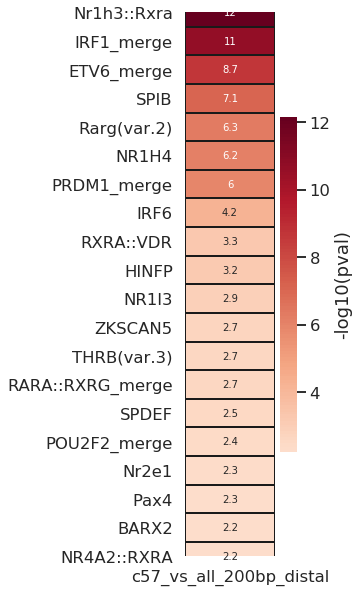

In [79]:
fig, ax = plt.subplots(figsize=(2,10))

filtered_frame = filtered_frame.sort_values('c57_vs_all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['c57_vs_all_200bp_distal']].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_c57_vs_all.png', bbox_inches='tight')

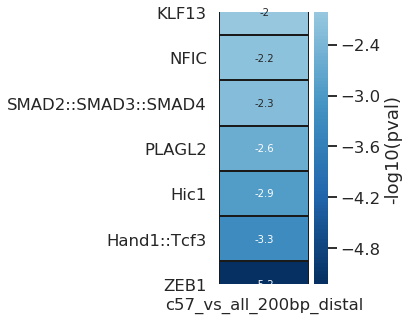

In [80]:
fig, ax = plt.subplots(figsize=(2,5))

filtered_frame = filtered_frame.sort_values('c57_vs_all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['c57_vs_all_200bp_distal']].dropna().tail(7),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_c57_vs_all.png', bbox_inches='tight')

### Including All comparisons

In [96]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    # read in signifance values using pandas
    df = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    # frame = frame[~frame.index.duplicated(keep='first')]
    pval = df.loc[:, 'Median p-val']

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

In [97]:
filtered_frame.columns

Index(['c57_vs_all_200bp_distal', 'c57_vs_all_200bp',
       'balbc_ajnew_200bp_distal', 'all_200bp_distal', 'all_200bp',
       'aj_c57_200bp', 'balbc_c57_200bp', 'balbc_c57_200bp_distal',
       'aj_c57_200bp_distal', 'balbc_aj_200bp'],
      dtype='object')

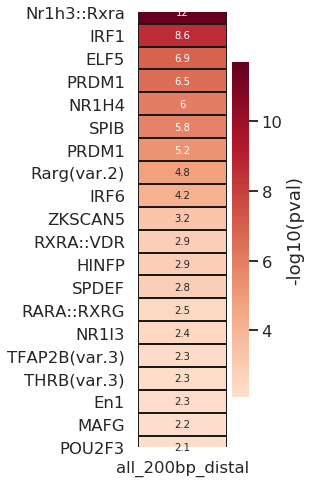

In [98]:
fig, ax = plt.subplots(figsize=(2,8))

filtered_frame = filtered_frame.sort_values('all_200bp_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp_distal']].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_all.png', bbox_inches='tight')

In [99]:
filtered_frame.loc[:, ['all_200bp_distal']].tail(10)

,all_200bp_distal
CEBPE,NaN
POU2F2,NaN
NFYA,NaN
ETV6,NaN
SMAD3,NaN
E2F3,NaN
GCM1,NaN
NFIX,NaN
ZIC1,NaN
NFIX,NaN


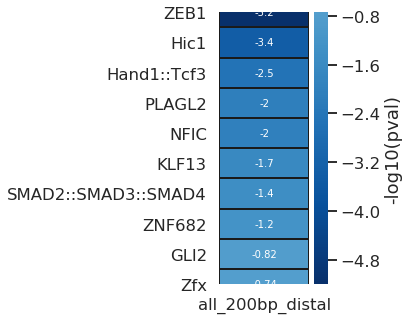

In [100]:
fig, ax = plt.subplots(figsize=(2,5))

filtered_frame = filtered_frame.sort_values('all_200bp_distal', ascending=True)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp_distal']].head(10),
    cmap='Blues_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_all.png', bbox_inches='tight')

In [14]:
rpkm = pd.read_csv('/gpfs/data01/glasslab/home/h1bennet/strains/data/RNA/HOMER.rawTPM.amln.txt', sep='\t')

# Look at TF Expression levels

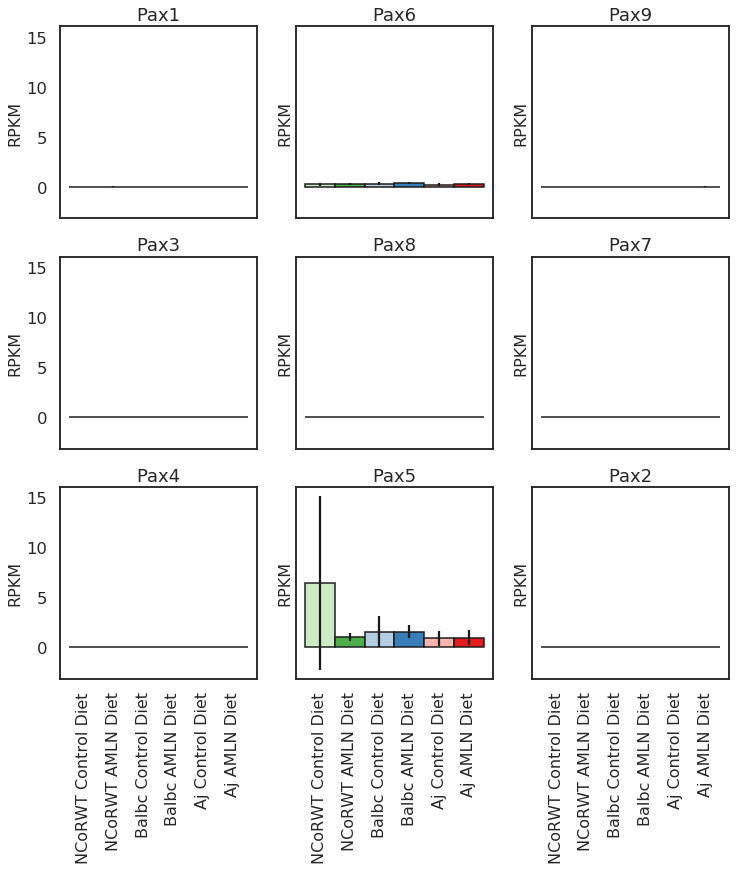

In [131]:
fig, axs = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)

count=0

for i in rpkm.loc[rpkm.index.str.contains('Pax[1-9]$'), :].index.tolist():
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

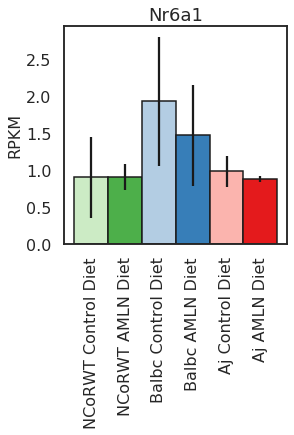

In [152]:
rpkm = survey_strain_amln_gene_exp('Nr6a1')

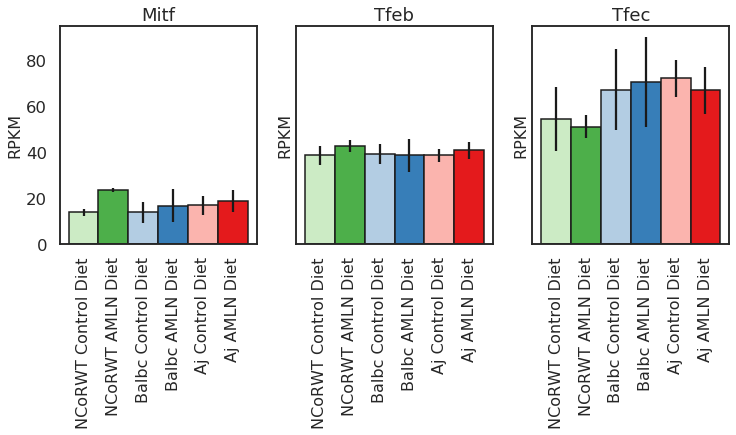

In [138]:
fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfeb', 'Tfec']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

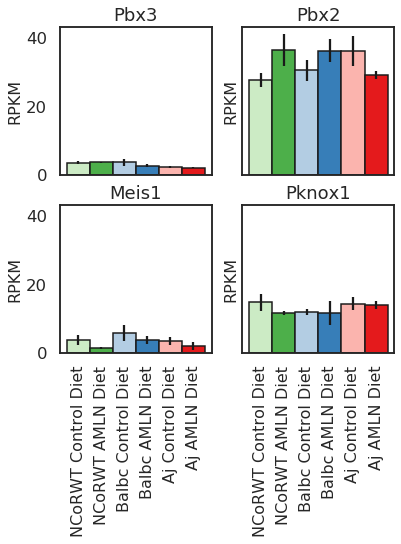

In [147]:
fig, axs = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)

count=0

for i in ['Pbx3', 'Pbx2', 'Meis1', 'Pknox1']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

In [149]:
rpkm.loc[rpkm.index.str.contains('Bach'), :]

,chr,start,end,strand,Length,Copies,Annotation/Divergence,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12a_16_12_1,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12b_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13a_JSSTDT_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,balbc_Tim4PosKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE1_CC1B_JSS_l20171006_GGTAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE2_CC1C_JSS_l20171006_ATGAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE3_CC1D_JSS_l20171006_ATTCC
gene,,,,,,,,,,,,,,,
Bach1,chr16,87698954,87733346,+,5851.0,1,Bach1|6230421P05Rik|AI323795|-|16|16 C3.3|prot...,42.284,47.377,38.528,52.811,30.577,40.853,39.973,40.023
Bach2os,chr4,32559680,32571662,-,1656.0,1,Bach2os|-|-|4|4 A5|ncRNA,39.409,36.493,44.942,33.432,28.295,55.059,41.474,48.139
Bach2,chr4,32417435,32586108,+,8486.0,1,Bach2|E030004N02Rik|-|4|4 A5|protein-coding,16.459,16.023,11.986,13.087,7.857,13.653,13.614,12.539


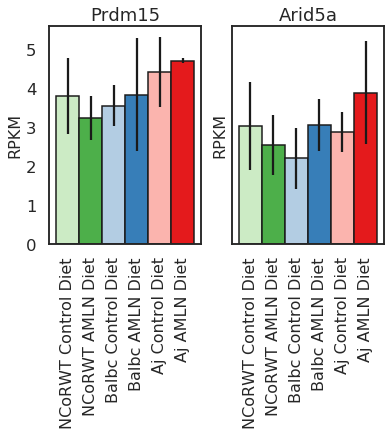

In [154]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Prdm15', 'Arid5a']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1